# Rest-of-Season Contact Rate Projection

**Author:** Your Name  
**Date:** (auto)

Projecting ROS contact rate using FH (through 2024-06-30) with uncertainty.

In [1]:
from pathlib import Path
import sys
import pandas as pd
import numpy as np

# Make sure Python can import from project root (so 'src/' works)
PROJECT_ROOT = Path("..").resolve()
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

DATA = PROJECT_ROOT / "data"
PITCH = DATA / "pitch_data.csv"
HITTER = DATA / "hitter_data.csv"

assert PITCH.exists() and HITTER.exists(), "Place pitch_data.csv and hitter_data.csv in ../data/"

# Load
p = pd.read_csv(PITCH, parse_dates=["pitch_date"])
h = pd.read_csv(HITTER)

print("pitch rows:", len(p), "hitter rows:", len(h))
print("pitch date range:", p["pitch_date"].min(), "→", p["pitch_date"].max())


pitch rows: 665200 hitter rows: 424
pitch date range: 2024-03-20 00:00:00 → 2024-09-30 00:00:00


In [ ]:
# 1. Data Processing & Feature Engineering

In [ ]:
# 1) (a) Defining contact rate

In [2]:
# Define contact rate (swing/contact flags)
# Normalize/clean the description strings
desc = p["description"].fillna("").str.strip()

# Define what counts as a SWING and what counts as CONTACT
SWING_DESCRIPTIONS = {
    "Swinging Strike",
    "Swinging Strike (Blocked)",
    "Foul",
    "Foul Tip",
    "Foul Bunt",
    "In play, out(s)",
    "In play, no out",
    "In play, run(s)",
}
CONTACT_DESCRIPTIONS = {
    "Foul",
    "Foul Tip",
    "Foul Bunt",
    "In play, out(s)",
    "In play, no out",
    "In play, run(s)",
}

# Flags
p["is_swing"]   = desc.isin(SWING_DESCRIPTIONS).astype(int)
p["is_contact"] = desc.isin(CONTACT_DESCRIPTIONS).astype(int)

# Quick sanity
print("Totals (overall): swings =", int(p["is_swing"].sum()), "contacts =", int(p["is_contact"].sum()))
print(p["description"].value_counts().head(15))


Totals (overall): swings = 318978 contacts = 245686
description
Ball                         221442
Foul                         120937
Called Strike                108545
In play, out(s)               76004
Swinging Strike               69638
In play, no out               25988
In play, run(s)               14938
Ball In Dirt                  14108
Foul Tip                       6739
Swinging Strike (Blocked)      3654
Hit By Pitch                   1899
Foul Bunt                      1080
Missed Bunt                     177
Pitchout                         49
Intent Ball                       2
Name: count, dtype: int64


In [ ]:
#Instead of using hard-coded for the swing description and contact description, now using robust rule

In [4]:
desc = p["description"].fillna("").str.strip()

# Contact = any 'Foul...' OR any 'In play, ...'
is_contact_rule = desc.str.contains(r"^foul", case=False, regex=True) | \
                  desc.str.contains(r"^in play", case=False, regex=True)

# Swing = contact OR a missed swing (swinging strikes, missed bunt)
is_swing_rule = is_contact_rule | desc.str.contains(r"^swinging strike", case=False) | \
                desc.str.contains(r"^missed bunt", case=False)

p["is_contact"] = is_contact_rule.astype(int)
p["is_swing"]   = is_swing_rule.astype(int)


In [6]:
print("Flag columns present:", {"is_contact": "is_contact" in p.columns,
                                "is_swing": "is_swing" in p.columns})

print("\nCounts:")
print("  contact=1:", int(p["is_contact"].sum()))
print("  swing=1  :", int(p["is_swing"].sum()))

print("\nCross-tab (swing vs contact):")
print(pd.crosstab(p["is_swing"], p["is_contact"]))

print("\nExamples of contact rows:")
display(p.loc[p["is_contact"].eq(1), ["description","is_swing","is_contact"]].head(10))

print("\nTop descriptions:")
display(p["description"].value_counts().head(20))

Flag columns present: {'is_contact': True, 'is_swing': True}

Counts:
  contact=1: 245686
  swing=1  : 319155

Cross-tab (swing vs contact):
is_contact       0       1
is_swing                  
0           346045       0
1            73469  245686

Examples of contact rows:


,description,is_swing,is_contact
3,"In play, out(s)",1,1
12,"In play, run(s)",1,1
20,Foul,1,1
22,Foul,1,1
23,Foul,1,1
24,"In play, no out",1,1
29,"In play, out(s)",1,1
31,"In play, out(s)",1,1
32,Foul,1,1
38,Foul,1,1



Top descriptions:


description
Ball                         221442
Foul                         120937
Called Strike                108545
In play, out(s)               76004
Swinging Strike               69638
In play, no out               25988
In play, run(s)               14938
Ball In Dirt                  14108
Foul Tip                       6739
Swinging Strike (Blocked)      3654
Hit By Pitch                   1899
Foul Bunt                      1080
Missed Bunt                     177
Pitchout                         49
Intent Ball                       2
Name: count, dtype: int64

In [ ]:
# 1) (b) Spliting the data appropriately

In [10]:
# Split the data appropriately (FH vs ROS)
CUTOFF = pd.Timestamp("2024-06-30")
p["half"] = np.where(p["pitch_date"] <= CUTOFF, "FH", "ROS")

print(p["half"].value_counts(dropna=False))
print(p.groupby("half")[["is_swing","is_contact"]].sum())


half
FH     346046
ROS    319154
Name: count, dtype: int64
      is_swing  is_contact
half                      
FH      165333      127727
ROS     153822      117959


In [11]:
# Aggregate to hitter-half and compute contact rate
# Aggregate by batter_id and half
agg = (
    p.groupby(["batter_id","half"], as_index=False)
      .agg(swings=("is_swing","sum"),
           contacts=("is_contact","sum"))
)

# Contact rate per half
agg["contact_rate"] = np.where(agg["swings"] > 0, agg["contacts"] / agg["swings"], np.nan)

# Pivot FH/ROS to columns
fh = (
    agg[agg["half"]=="FH"]
    .drop(columns=["half"])
    .rename(columns={"swings":"swings_FH","contacts":"contacts_FH","contact_rate":"contact_rate_FH"})
)
ros = (
    agg[agg["half"]=="ROS"]
    .drop(columns=["half"])
    .rename(columns={"swings":"swings_ROS","contacts":"contacts_ROS","contact_rate":"contact_rate_ROS"})
)

tbl = fh.merge(ros, on="batter_id", how="inner")
print("hitters with both FH & ROS:", len(tbl))
tbl.head()


hitters with both FH & ROS: 408


,batter_id,swings_FH,contacts_FH,contact_rate_FH,swings_ROS,contacts_ROS,contact_rate_ROS
0,444482,140,111,0.792857,376,276,0.734043
1,453568,463,390,0.842333,458,372,0.812227
2,455117,241,162,0.672199,33,20,0.606061
3,456781,284,224,0.788732,317,249,0.785489
4,457705,525,386,0.735238,383,283,0.738903


In [ ]:
# 1) (c)Creating multiple features engineerings that are relevant for modeling contact rate and comparing at last

In [12]:
# 0) Build a clean base table (no metadata merged yet)
# Rebuild a clean base to avoid double-merges
fh = (
    agg[agg["half"]=="FH"].drop(columns=["half"])
      .rename(columns={"swings":"swings_FH","contacts":"contacts_FH","contact_rate":"contact_rate_FH"})
)
ros = (
    agg[agg["half"]=="ROS"].drop(columns=["half"])
      .rename(columns={"swings":"swings_ROS","contacts":"contacts_ROS","contact_rate":"contact_rate_ROS"})
)
tbl_base = fh.merge(ros, on="batter_id", how="inner")
# Keep valid rows only
tbl_base = tbl_base[(tbl_base["swings_FH"]>0) & (tbl_base["swings_ROS"]>0)].dropna(subset=["contact_rate_FH","contact_rate_ROS"]).copy()


In [13]:
tbl_base.head()


,batter_id,swings_FH,contacts_FH,contact_rate_FH,swings_ROS,contacts_ROS,contact_rate_ROS
0,444482,140,111,0.792857,376,276,0.734043
1,453568,463,390,0.842333,458,372,0.812227
2,455117,241,162,0.672199,33,20,0.606061
3,456781,284,224,0.788732,317,249,0.785489
4,457705,525,386,0.735238,383,283,0.738903


In [14]:
# 1) Helper 
import numpy as np, pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

def _safe_col(df, col): return col in df.columns

def kfold_mae(X, y, n_splits=5, alpha=1.0, random_state=42):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    maes = []
    for tr, te in kf.split(X):
        Xtr, Xte = X.iloc[tr], X.iloc[te]
        ytr, yte = y.iloc[tr], y.iloc[te]
        scaler = StandardScaler()
        Xtr_s = scaler.fit_transform(Xtr)
        Xte_s = scaler.transform(Xte)
        model = Ridge(alpha=alpha)
        model.fit(Xtr_s, ytr)
        p = model.predict(Xte_s)
        maes.append(mean_absolute_error(yte, p))
    return float(np.mean(maes))


In [15]:
print(kfold_mae)


<function kfold_mae at 0x11748d080>


In [16]:
# Variant V0 — Metadata baseline

def features_v0_metadata(tbl_base: pd.DataFrame, h: pd.DataFrame) -> pd.DataFrame:
    out = tbl_base.merge(h, on="batter_id", how="left")
    out["sqrt_swings_FH"] = np.sqrt(out["swings_FH"].clip(lower=0))

    if "contact_rate_2023" in out.columns:
        out["delta_2023_FH"] = out["contact_rate_FH"] - out["contact_rate_2023"]
    if "total_swings_2023" in out.columns:
        out["log_swings_2023"] = np.log1p(out["total_swings_2023"])
    if "batter_stand" in out.columns:
        out["is_lefty"] = (out["batter_stand"].astype(str).str.upper()=="L").astype(int)

    keep = [c for c in [
        "batter_id","contact_rate_ROS",
        "contact_rate_FH","swings_FH","sqrt_swings_FH",
        "contact_rate_2023","total_swings_2023","log_swings_2023","delta_2023_FH",
        "is_lefty","age"
    ] if c in out.columns]
    return out[keep]


In [17]:
# Variant V1 — Minimal, high-signal

def features_v1_minimal(tbl_base: pd.DataFrame, h: pd.DataFrame) -> pd.DataFrame:
    out = tbl_base.merge(h, on="batter_id", how="left")
    out["sqrt_swings_FH"] = np.sqrt(out["swings_FH"].clip(lower=0))
    if "contact_rate_2023" in out.columns:
        out["delta_2023_FH"] = out["contact_rate_FH"] - out["contact_rate_2023"]
    if "total_swings_2023" in out.columns:
        out["log_swings_2023"] = np.log1p(out["total_swings_2023"])
    if "batter_stand" in out.columns:
        out["is_lefty"] = (out["batter_stand"].astype(str).str.upper()=="L").astype(int)

    keep = [c for c in [
        "batter_id","contact_rate_ROS",
        "contact_rate_FH","swings_FH","sqrt_swings_FH",
        "contact_rate_2023","total_swings_2023","log_swings_2023","delta_2023_FH",
        "is_lefty","age"
    ] if c in out.columns]
    return out[keep]


In [18]:
v1_test = features_v1_minimal(tbl_base, h)
v1_test.head()


,batter_id,contact_rate_ROS,contact_rate_FH,swings_FH,sqrt_swings_FH,contact_rate_2023,total_swings_2023,log_swings_2023,delta_2023_FH
0,444482,0.734043,0.792857,140,11.832160,0.7743,833.0,6.726233,0.018557
1,453568,0.812227,0.842333,463,21.517435,0.8052,724.0,6.586172,0.037133
2,455117,0.606061,0.672199,241,15.524175,0.6572,776.0,6.655440,0.014999
3,456781,0.785489,0.788732,284,16.852300,0.7488,864.0,6.762730,0.039932
4,457705,0.738903,0.735238,525,22.912878,NaN,NaN,NaN,NaN


In [19]:
# Variant V2 — Approach profile (unchanged logic; uses p)

def features_v2_approach(pitch_df: pd.DataFrame, tbl_base: pd.DataFrame) -> pd.DataFrame:
    pFH = pitch_df[pitch_df["half"] == "FH"].copy()
    desc = pFH["description"].fillna("").str.strip()

    # build swing components within FH using distinct names to avoid collisions
    g = pFH.groupby("batter_id", as_index=False).agg(
        swings_FH_g=("is_swing", "sum"),
        whiffs_FH=("description", lambda s: int((s.isin({"Swinging Strike","Swinging Strike (Blocked)"})).sum())),
        fouls_FH=("description",  lambda s: int((s.isin({"Foul","Foul Tip","Foul Bunt"})).sum())),
        inplay_FH=("description", lambda s: int((s.isin({"In play, out(s)","In play, no out","In play, run(s)"})).sum())),
    )

    # rates within swings (computed using g['swings_FH_g'], not tbl_base)
    g["whiff_rate_FH"]   = np.where(g["swings_FH_g"] > 0, g["whiffs_FH"] / g["swings_FH_g"], np.nan)
    g["foul_share_FH"]   = np.where(g["swings_FH_g"] > 0, g["fouls_FH"]  / g["swings_FH_g"], np.nan)
    g["inplay_share_FH"] = np.where(g["swings_FH_g"] > 0, g["inplay_FH"] / g["swings_FH_g"], np.nan)

    # optional: two-strike contact rate if balls/strikes exist
    if {"balls","strikes"}.issubset(pFH.columns):
        two_strike = pFH[pFH["strikes"] >= 2]
        tsg = two_strike.groupby("batter_id", as_index=False).agg(
            ts_swings=("is_swing","sum"),
            ts_contacts=("is_contact","sum"),
        )
        tsg["two_strike_contact_rate_FH"] = np.where(tsg["ts_swings"] > 0, tsg["ts_contacts"] / tsg["ts_swings"], np.nan)
        g = g.merge(tsg[["batter_id","two_strike_contact_rate_FH"]], on="batter_id", how="left")

    # keep only rate columns to avoid any name clashes on merge
    g = g[["batter_id","whiff_rate_FH","foul_share_FH","inplay_share_FH","two_strike_contact_rate_FH"]\
           if "two_strike_contact_rate_FH" in g.columns
           else ["batter_id","whiff_rate_FH","foul_share_FH","inplay_share_FH"]]

    out = tbl_base.merge(g, on="batter_id", how="left")
    out["sqrt_swings_FH"] = np.sqrt(out["swings_FH"].clip(lower=0))

    keep = [c for c in [
        "batter_id","contact_rate_ROS",
        "contact_rate_FH","swings_FH","sqrt_swings_FH",
        "whiff_rate_FH","foul_share_FH","inplay_share_FH","two_strike_contact_rate_FH"
    ] if c in out.columns]
    return out[keep]


In [20]:
v2_test = features_v2_approach(p, tbl_base)
v2_test.head()


,batter_id,contact_rate_ROS,contact_rate_FH,swings_FH,sqrt_swings_FH,whiff_rate_FH,foul_share_FH,inplay_share_FH
0,444482,0.734043,0.792857,140,11.832160,0.207143,0.471429,0.321429
1,453568,0.812227,0.842333,463,21.517435,0.157667,0.425486,0.416847
2,455117,0.606061,0.672199,241,15.524175,0.327801,0.356846,0.315353
3,456781,0.785489,0.788732,284,16.852300,0.211268,0.426056,0.362676
4,457705,0.738903,0.735238,525,22.912878,0.264762,0.382857,0.352381


In [21]:
# Variant V3 — Pitch-mix + platoon (uses p + h)

def features_v3_mix_platoon(pitch_df: pd.DataFrame, tbl_base: pd.DataFrame, h: pd.DataFrame) -> pd.DataFrame:
    # --- Coarse pitch-type buckets
    pitch_map = {
        "FF":"fast","FT":"fast","SI":"fast","FA":"fast","FC":"fast","FS":"fast",
        "SL":"break","CU":"break","KC":"break","SC":"break","KN":"break",
        "CH":"off","FO":"off","EP":"off","CS":"off"
    }

    pFH = pitch_df[pitch_df["half"] == "FH"].copy()

    # ---------- Pitch mix shares (fast / break / off / other)
    mix = pd.DataFrame({"batter_id": []})
    if "pitch_type" in pFH.columns:
        pFH["mix_bucket"] = pFH["pitch_type"].map(pitch_map).fillna("other")
        # counts by batter x bucket
        cnts = (pFH
                .pivot_table(index="batter_id", columns="mix_bucket",
                             values="pitch_type", aggfunc="size", fill_value=0)
                .astype(float))
        # row-normalize to shares
        shares = cnts.div(cnts.sum(axis=1).replace(0, np.nan), axis=0).fillna(0)
        # friendly column names
        shares = shares.rename(columns={
            "fast":"fastball_share_FH",
            "break":"breaking_share_FH",
            "off":"offspeed_share_FH",
            "other":"other_share_FH"
        })
        mix = shares.reset_index()  # 'batter_id' only once here

    # ---------- Platoon exposure (same-hand share)
    pl = pd.DataFrame({"batter_id": []})
    if "p_throws" in pFH.columns and "batter_stand" in h.columns:
        tmp = pFH.merge(h[["batter_id","batter_stand"]], on="batter_id", how="left")
        tmp["same_hand"] = (
            tmp["batter_stand"].astype(str).str.upper()
            == tmp["p_throws"].astype(str).str.upper()
        ).astype(int)
        pl = (tmp.groupby("batter_id", as_index=False)["same_hand"]
                .mean()
                .rename(columns={"same_hand":"same_hand_share_FH"}))

    # ---------- Merge with base table
    g = tbl_base.merge(mix, on="batter_id", how="left").merge(pl, on="batter_id", how="left")

    # Core volume stabilizer + interactions
    g["sqrt_swings_FH"] = np.sqrt(g["swings_FH"].clip(lower=0))
    for col in ["fastball_share_FH","breaking_share_FH","offspeed_share_FH","same_hand_share_FH"]:
        if col in g.columns:
            g[f"contact_x_{col}"] = g["contact_rate_FH"] * g[col]

    keep = [c for c in [
        "batter_id","contact_rate_ROS",
        "contact_rate_FH","swings_FH","sqrt_swings_FH",
        "fastball_share_FH","breaking_share_FH","offspeed_share_FH","other_share_FH",
        "same_hand_share_FH",
        "contact_x_fastball_share_FH","contact_x_breaking_share_FH",
        "contact_x_offspeed_share_FH","contact_x_same_hand_share_FH"
    ] if c in g.columns]
    return g[keep]



In [22]:
v3_test = features_v3_mix_platoon(p, tbl_base, h)
v3_test.head()


,batter_id,contact_rate_ROS,contact_rate_FH,swings_FH,sqrt_swings_FH,fastball_share_FH,breaking_share_FH,offspeed_share_FH,other_share_FH,contact_x_fastball_share_FH,contact_x_breaking_share_FH,contact_x_offspeed_share_FH
0,444482,0.734043,0.792857,140,11.832160,0.671698,0.139623,0.143396,0.045283,0.532561,0.110701,0.113693
1,453568,0.812227,0.842333,463,21.517435,0.661376,0.196825,0.102646,0.039153,0.557098,0.165792,0.086462
2,455117,0.606061,0.672199,241,15.524175,0.610998,0.254582,0.052953,0.081466,0.410712,0.171130,0.035595
3,456781,0.785489,0.788732,284,16.852300,0.594507,0.256866,0.085622,0.063005,0.468907,0.202598,0.067533
4,457705,0.738903,0.735238,525,22.912878,0.571772,0.282277,0.089816,0.056135,0.420389,0.207541,0.066036


In [23]:
# Building all 4 and comparing

v0 = features_v0_metadata(tbl_base, h)
v1 = features_v1_minimal(tbl_base, h)
v2 = features_v2_approach(p, tbl_base)
v3 = features_v3_mix_platoon(p, tbl_base, h)

def compare_feature_sets(*sets, labels=None):
    if labels is None: labels = [f"set_{i+1}" for i in range(len(sets))]
    rows = []
    for s, lab in zip(sets, labels):
        s_ = s.dropna(axis=0)  # simple fairness
        y = s_["contact_rate_ROS"]
        X = s_.drop(columns=["batter_id","contact_rate_ROS"], errors="ignore")
        if X.shape[1] == 0 or len(s_) < 30:  # guardrail
            rows.append({"set": lab, "kfold_MAE": np.nan, "n": len(s_), "p": X.shape[1]})
            continue
        mae = kfold_mae(X, y, n_splits=5, alpha=1.0)
        rows.append({"set": lab, "kfold_MAE": mae, "n": len(s_), "p": X.shape[1]})
    return pd.DataFrame(rows).sort_values("kfold_MAE")

compare_feature_sets(v0, v1, v2, v3, labels=["metadata_baseline","minimal","approach","mix_platoon"])


,set,kfold_MAE,n,p
0,metadata_baseline,0.029955,374,7
1,minimal,0.029955,374,7
2,approach,0.032652,408,6
3,mix_platoon,0.033470,408,10


In [28]:
import numpy as np
import pandas as pd
from IPython.display import display

# If kfold_mae is not already defined in your notebook, this lightweight fallback works:
try:
    kfold_mae
except NameError:
    from sklearn.model_selection import KFold
    from sklearn.preprocessing import StandardScaler
    from sklearn.linear_model import LinearRegression
    from sklearn.metrics import mean_absolute_error

    def kfold_mae(X, y, n_splits=5, alpha=1.0, random_state=42):
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
        maes = []
        for tr, te in kf.split(X):
            Xtr, Xte = X.iloc[tr], X.iloc[te]
            ytr, yte = y.iloc[tr], y.iloc[te]
            scaler = StandardScaler()
            Xtr_s = scaler.fit_transform(Xtr)
            Xte_s = scaler.transform(Xte)
            model = LinearRegression()
            model.fit(Xtr_s, ytr)
            pred = model.predict(Xte_s)
            maes.append(mean_absolute_error(yte, pred))
        return float(np.mean(maes))

def eval_feature_set(tbl, target_col="contact_rate_ROS", drop_cols=("batter_id","contact_rate_ROS"),
                     n_splits=5, alpha=1.0, random_state=42):
    s = tbl.dropna(axis=0)
    y = s[target_col].astype(float)
    X = s.drop(columns=list(drop_cols), errors="ignore")
    if X.shape[1] == 0 or len(s) < max(30, n_splits):
        return {"kfold_MAE": float("nan"), "n": len(s), "p": X.shape[1]}
    mae = kfold_mae(X, y, n_splits=n_splits, alpha=alpha, random_state=random_state)
    return {"kfold_MAE": float(mae), "n": len(s), "p": X.shape[1]}

def pick_best_feature_set(candidates, prefer="minimal", n_splits=5, seed=42):
    rows = []
    for name, t in candidates.items():
        m = eval_feature_set(t, n_splits=n_splits, random_state=seed)
        m["set"] = name
        rows.append(m)
    cmp_df = pd.DataFrame(rows).sort_values(["kfold_MAE","p","n","set"],
                                            ascending=[True, True, False, True]).reset_index(drop=True)
    print(cmp_df)

    # Tie break: if top two MAEs are equal (within 1e-6), prefer `prefer` if available
    best = cmp_df.iloc[0]["set"]
    if len(cmp_df) > 1 and abs(cmp_df.iloc[0]["kfold_MAE"] - cmp_df.iloc[1]["kfold_MAE"]) < 1e-6:
        if prefer in candidates:
            best = prefer

    return best, candidates[best].copy()

# --- assumes v0..v3 already exist from your earlier cells ---
candidates = {
    "metadata_baseline": v0,
    "minimal": v1,
    "approach": v2,
    "mix_platoon": v3,
}

winner_label, tbl = pick_best_feature_set(candidates, prefer="minimal", n_splits=5, seed=42)
print(f"\nSelected feature set: {winner_label}")
print(f"Rows: {len(tbl):,}, Columns: {tbl.shape[1]}")
display(tbl.head(10))


   kfold_MAE    n   p                set
0   0.029955  374   7  metadata_baseline
1   0.029955  374   7            minimal
2   0.032652  408   6           approach
3   0.033470  408  10        mix_platoon

Selected feature set: minimal
Rows: 408, Columns: 9


,batter_id,contact_rate_ROS,contact_rate_FH,swings_FH,sqrt_swings_FH,contact_rate_2023,total_swings_2023,log_swings_2023,delta_2023_FH
0,444482,0.734043,0.792857,140,11.832160,0.7743,833.0,6.726233,0.018557
1,453568,0.812227,0.842333,463,21.517435,0.8052,724.0,6.586172,0.037133
2,455117,0.606061,0.672199,241,15.524175,0.6572,776.0,6.655440,0.014999
3,456781,0.785489,0.788732,284,16.852300,0.7488,864.0,6.762730,0.039932
4,457705,0.738903,0.735238,525,22.912878,NaN,NaN,NaN,NaN
5,457759,0.832653,0.863475,564,23.748684,NaN,NaN,NaN,NaN
6,467793,0.779324,0.793419,547,23.388031,0.7790,1113.0,7.015712,0.014419
7,500743,0.863946,0.888476,269,16.401219,0.8343,718.0,6.577861,0.054176
8,502054,0.777778,0.798271,347,18.627936,0.7642,776.0,6.655440,0.034071
9,502110,0.674858,0.736052,466,21.587033,0.6541,983.0,6.891626,0.081952


In [ ]:
'''Minimal feature engineering is the best because the minimal set is the cleanest dependency-wise (just the core columns plus a 
couple of robust transforms), which makes it easier to explain and less brittle if some metadata fields are missing or messy.'''

In [ ]:
# 1) (d) Handling missing data appropriately

In [29]:
# Handle missing data appropriately
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer

id_col = "batter_id"
target = "contact_rate_ROS"
feature_cols = [c for c in tbl.columns if c not in (id_col, target)]

# 1) Missingness report
missing = tbl[feature_cols].isna().mean().sort_values(ascending=False)
print("Missing rate by feature (top 20):")
display(missing.head(20))

# 2) Missingness indicators
miss_cols = [c for c in feature_cols if tbl[c].isna().any()]
for c in miss_cols:
    tbl[f"m_{c}"] = tbl[c].isna().astype(int)

# 3) Median impute numeric features
imputer = SimpleImputer(strategy="median")
tbl[feature_cols] = imputer.fit_transform(tbl[feature_cols])

# 4) Safety-clip rates/shares to [0,1]
rate_like = [c for c in tbl.columns if any(k in c.lower() for k in
                                           ["rate","share","theta","p_","contact_x_"])]
for c in rate_like:
    if c in tbl.columns:
        tbl[c] = tbl[c].clip(lower=0.0, upper=1.0)

# 5) Final matrices
final_features = [c for c in tbl.columns if c not in (id_col, target)]
X_clean = tbl[final_features].copy()
y = tbl[target].copy()

print(f"\nAfter imputation: X_clean shape={X_clean.shape}, y shape={y.shape}")
display(X_clean.head(6))


Missing rate by feature (top 20):


contact_rate_2023    0.083333
delta_2023_FH        0.083333
total_swings_2023    0.004902
log_swings_2023      0.004902
contact_rate_FH      0.000000
swings_FH            0.000000
sqrt_swings_FH       0.000000
dtype: float64


After imputation: X_clean shape=(408, 11), y shape=(408,)


,contact_rate_FH,swings_FH,sqrt_swings_FH,contact_rate_2023,total_swings_2023,log_swings_2023,delta_2023_FH,m_contact_rate_2023,m_total_swings_2023,m_log_swings_2023,m_delta_2023_FH
0,0.792857,140.0,11.832160,0.77430,833.0,6.726233,0.018557,0,0,0,0
1,0.842333,463.0,21.517435,0.80520,724.0,6.586172,0.037133,0,0,0,0
2,0.672199,241.0,15.524175,0.65720,776.0,6.655440,0.014999,0,0,0,0
3,0.788732,284.0,16.852300,0.74880,864.0,6.762730,0.039932,0,0,0,0
4,0.735238,525.0,22.912878,0.74795,694.0,6.543875,0.026727,1,1,1,1
5,0.863475,564.0,23.748684,0.74795,694.0,6.543875,0.026727,1,1,1,1


In [30]:
# No NaNs left?
print("Any NaNs in X_clean?", X_clean.isna().any().any())
print("Any NaNs in y?", y.isna().any())

# Feature list you’ll feed to the model
print("Features:", list(X_clean.columns))

# Basic ranges (look for values outside [0,1] for rate/share columns)
X_clean.describe(percentiles=[.05,.5,.95]).T.head(20)


Any NaNs in X_clean? False
Any NaNs in y? False
Features: ['contact_rate_FH', 'swings_FH', 'sqrt_swings_FH', 'contact_rate_2023', 'total_swings_2023', 'log_swings_2023', 'delta_2023_FH', 'm_contact_rate_2023', 'm_total_swings_2023', 'm_log_swings_2023', 'm_delta_2023_FH']


,count,mean,std,min,5%,50%,95%,max
contact_rate_FH,408.0,0.768528,0.064021,0.448276,0.669248,0.772064,0.867968,0.946429
swings_FH,408.0,397.191176,185.440634,5.000000,97.350000,398.000000,684.650000,830.000000
sqrt_swings_FH,408.0,19.229302,5.243329,2.236068,9.866581,19.949922,26.165816,28.809721
contact_rate_2023,408.0,0.743571,0.059915,0.555900,0.634770,0.747950,0.840230,0.921700
total_swings_2023,408.0,662.107843,407.169903,0.000000,0.000000,694.000000,1294.200000,1445.000000
log_swings_2023,408.0,5.862614,1.869164,0.000000,0.000000,6.543875,7.166416,7.276556
delta_2023_FH,408.0,0.026116,0.043124,-0.192324,-0.044122,0.026727,0.093978,0.221976
m_contact_rate_2023,408.0,0.083333,0.276725,0.000000,0.000000,0.000000,1.000000,1.000000
m_total_swings_2023,408.0,0.004902,0.069928,0.000000,0.000000,0.000000,0.000000,1.000000
m_log_swings_2023,408.0,0.004902,0.069928,0.000000,0.000000,0.000000,0.000000,1.000000


In [ ]:
# 2. Model Development(Checked 3 models and chose the best)

In [31]:
# Small helpers (metrics + tidy outputs)
import numpy as np
import pandas as pd
from scipy.stats import beta
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

def regression_metrics(yhat, ytrue):
    return {
        "MAE": float(np.mean(np.abs(yhat - ytrue))),
        "RMSE": float(np.sqrt(np.mean((yhat - ytrue)**2))),
    }

def coverage(ytrue, lo, hi):
    return float(np.mean((ytrue >= lo) & (ytrue <= hi)))

def print_section(title):
    print("\n" + "="*len(title))
    print(title)
    print("="*len(title))


In [ ]:
#Model A — Empirical Bayes (Beta–Binomial “stabilizer”)

In [32]:
# --- Build FH binomial counts from tbl ---
contacts_FH = (tbl["contact_rate_FH"] * tbl["swings_FH"]).round().astype(int).clip(lower=0)
swings_FH   = tbl["swings_FH"].astype(int).clip(lower=0)

# --- Estimate Beta prior (method of moments) ---
p_hat = np.where(swings_FH>0, contacts_FH / swings_FH, np.nan)
m  = np.nanmean(p_hat)
v  = np.nanvar(p_hat, ddof=1)
# guardrails
v  = max(v, 1e-6)
alpha0 = m * (m * (1 - m) / v - 1)
beta0  = (1 - m) * (m * (1 - m) / v - 1)
alpha0 = float(max(alpha0, 1e-3))
beta0  = float(max(beta0,  1e-3))

# --- Posterior per hitter ---
post_a = alpha0 + contacts_FH
post_b = beta0  + (swings_FH - contacts_FH)
p_mean = post_a / (post_a + post_b)
p_lo80 = beta.ppf(0.10, post_a, post_b)   # 80% interval
p_hi80 = beta.ppf(0.90, post_a, post_b)

eb_df = pd.DataFrame({
    "batter_id": tbl["batter_id"].values,
    "proj_p": p_mean,
    "lo80": p_lo80,
    "hi80": p_hi80,
})
print_section("Model A: Empirical Bayes (Beta–Binomial)")
print(f"Prior alpha0={alpha0:.2f}, beta0={beta0:.2f} (mean≈{alpha0/(alpha0+beta0):.3f})")

# Backtest vs actual ROS (for report; interviewer will like this)
mA = regression_metrics(eb_df["proj_p"].values, tbl["contact_rate_ROS"].values)
covA = coverage(tbl["contact_rate_ROS"].values, eb_df["lo80"].values, eb_df["hi80"].values)
print({"MAE": mA["MAE"], "RMSE": mA["RMSE"], "Coverage_80": covA})
eb_df.head(10)



Model A: Empirical Bayes (Beta–Binomial)
Prior alpha0=32.59, beta0=9.81 (mean≈0.769)
{'MAE': 0.03254647587457855, 'RMSE': 0.04282945212125634, 'Coverage_80': 0.5147058823529411}


,batter_id,proj_p,lo80,hi80
0,444482,0.787202,0.747782,0.825262
1,453568,0.836141,0.814782,0.856928
2,455117,0.686612,0.651048,0.721609
3,456781,0.786108,0.756684,0.814777
4,457705,0.737726,0.713894,0.761198
5,457759,0.856836,0.838380,0.874787
6,467793,0.791628,0.769993,0.812838
7,500743,0.872143,0.847448,0.895810
8,502054,0.795032,0.768522,0.820891
9,502110,0.738760,0.713606,0.763511


In [50]:
# Sanity checks on the EB outputs you selected
cols_needed = ["batter_id","proj_p","lo80","hi80","contact_rate_ROS"]
print("All columns present:", all(c in eb_df.columns for c in cols_needed))

# Intervals proper and bounded
print("Any lo>hi? ", (eb_df["lo80"] > eb_df["hi80"]).sum())
print("Any out of [0,1]? ",
      ((eb_df[["proj_p","lo80","hi80"]] < 0).any().any(),
       (eb_df[["proj_p","lo80","hi80"]] > 1).any().any()))

# Interval width vs sample size (should trend narrower with more FH swings)
chk = eb_df.merge(tbl_best[["batter_id","swings_FH"]], on="batter_id", how="left")
chk["width"] = chk["hi80"] - chk["lo80"]
print(chk[["swings_FH","width"]].corr())

All columns present: True
Any lo>hi?  0
Any out of [0,1]?  (np.False_, np.False_)
           swings_FH     width
swings_FH   1.000000 -0.831148
width      -0.831148  1.000000


In [52]:
print(f"Total hitters projected: {eb_df['batter_id'].nunique()}")


Total hitters projected: 408


In [59]:
# Exporting the 408 records to .cvs file inside reports folder
# --- Final deliverable: full ROS projections for every hitter (EB model) ---

# eb_out = eb_df.merge(h[['batter_id','batter_name']], on='batter_id', how='left')

eb_out = eb_df.copy()

# Helpful extras for the reader
if 'contact_rate_FH' in tbl_best.columns and 'batter_id' in tbl_best.columns:
    eb_out = eb_out.merge(tbl_best[['batter_id','contact_rate_FH','swings_FH']], 
                          on='batter_id', how='left')
    eb_out['delta_vs_FH'] = eb_out['proj_p'] - eb_out['contact_rate_FH']
eb_out['ci80_width'] = eb_out['hi80'] - eb_out['lo80']

# Order columns nicely (keep only those that exist)
cols = [c for c in [
    'batter_id',               # or 'batter_name' if you merged names
    'swings_FH', 'contact_rate_FH',
    'proj_p', 'lo80', 'hi80', 'ci80_width', 'delta_vs_FH'
] if c in eb_out.columns]
eb_out = eb_out[cols]

# Sanity checks
print(f"Total hitters projected: {eb_out['batter_id'].nunique()}")
display(eb_out.head(10))

# Save artifacts for the deliverable
eb_out.to_csv("/Users/atishchandra/Downloads/untitled/Hitter_Contact_Rate/reports/ros_contact_projections.csv", index=False)
with open("reports/README_models.txt", "w") as f:
    f.write(
        "Rest-of-Season Contact Rate Projections (Empirical Bayes / Beta-Binomial)\n"
        f"Total hitters: {eb_out['batter_id'].nunique()}\n"
        "Columns:\n"
        "  batter_id: unique hitter id\n"
        "  swings_FH: FH swings used for reliability (if present)\n"
        "  contact_rate_FH: FH contact rate (if present)\n"
        "  proj_p: projected ROS contact rate\n"
        "  lo80, hi80: 80% credible interval for proj_p\n"
        "  ci80_width: interval width (uncertainty)\n"
        "  delta_vs_FH: shrink-adjusted change vs FH (if FH columns present)\n"
        "\nModel notes: EB shrinks hitter FH rates toward a league beta prior, "
        "so small-sample hitters get stronger pull to the prior; large-sample hitters "
        "track closer to their FH rate. Intervals widen with fewer swings.\n"
    )

print("✅ Wrote full projections to reports/ros_contact_projections.csv")


Total hitters projected: 408


,batter_id,swings_FH,contact_rate_FH,proj_p,lo80,hi80,ci80_width,delta_vs_FH
0,444482,140,0.792857,0.787202,0.747782,0.825262,0.077481,-0.005656
1,453568,463,0.842333,0.836141,0.814782,0.856928,0.042147,-0.006192
2,455117,241,0.672199,0.686612,0.651048,0.721609,0.070561,0.014412
3,456781,284,0.788732,0.786108,0.756684,0.814777,0.058094,-0.002625
4,457705,525,0.735238,0.737726,0.713894,0.761198,0.047303,0.002488
5,457759,564,0.863475,0.856836,0.838380,0.874787,0.036408,-0.006639
6,467793,547,0.793419,0.791628,0.769993,0.812838,0.042845,-0.001791
7,500743,269,0.888476,0.872143,0.847448,0.895810,0.048362,-0.016333
8,502054,347,0.798271,0.795032,0.768522,0.820891,0.052368,-0.003239
9,502110,466,0.736052,0.738760,0.713606,0.763511,0.049905,0.002709


✅ Wrote full projections to reports/ros_contact_projections.csv


In [58]:
import os
print(os.getcwd())


/Users/atishchandra/Downloads/untitled/Hitter_Contact_Rate/notebooks


In [ ]:
#Model B — Weighted Logistic Regression (GLM, Binomial, logit)

In [33]:
import statsmodels.api as sm

# Choose predictors (you can tweak)
feature_cols = [c for c in [
    "contact_rate_FH", "sqrt_swings_FH",
    "contact_rate_2023", "total_swings_2023",
] if c in tbl.columns]

# Design matrix & target
X = tbl[feature_cols].copy()
X = sm.add_constant(X)  # intercept
y_num = (tbl["contact_rate_ROS"] * tbl["swings_FH"]).round().astype(int)
n_num = tbl["swings_FH"].astype(int).clip(lower=1)   # avoid 0
y_prop = y_num / n_num

# Fit GLM Binomial with frequency weights = n
glm_binom = sm.GLM(y_prop, X, family=sm.families.Binomial(), freq_weights=n_num)
res = glm_binom.fit()
print_section("Model B: GLM Binomial (weighted by swings)")
print(res.summary().as_text())

# Predictions on same hitters (projection)
linpred = np.dot(X, res.params)                      # on logit scale
# get SE via delta: Var(η) = diag(X V X^T)
V = res.cov_params()
se_lin = np.sqrt(np.sum((X @ V) * X, axis=1))        # per-row SE of linear predictor

# 80% Wald CI on logit scale (z=1.2816)
z = 1.2816
lin_lo = linpred - z * se_lin
lin_hi = linpred + z * se_lin
proj_p  = 1 / (1 + np.exp(-linpred))
lo80    = 1 / (1 + np.exp(-lin_lo))
hi80    = 1 / (1 + np.exp(-lin_hi))

glm_df = pd.DataFrame({
    "batter_id": tbl["batter_id"].values,
    "proj_p": proj_p,
    "lo80": lo80,
    "hi80": hi80,
})
mB = regression_metrics(glm_df["proj_p"].values, tbl["contact_rate_ROS"].values)
covB = coverage(tbl["contact_rate_ROS"].values, glm_df["lo80"].values, glm_df["hi80"].values)
print({"MAE": mB["MAE"], "RMSE": mB["RMSE"], "Coverage_80": covB})
glm_df.head(10)



Model B: GLM Binomial (weighted by swings)
                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                  408
Model:                            GLM   Df Residuals:                   162049
Model Family:                Binomial   Df Model:                            4
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -59043.
Date:                Wed, 05 Nov 2025   Deviance:                       1283.8
Time:                        13:47:50   Pearson chi2:                 1.27e+03
No. Iterations:                     5   Pseudo R-squ. (CS):             0.9984
Covariance Type:            nonrobust                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------

,batter_id,proj_p,lo80,hi80
0,444482,0.789856,0.785713,0.793939
1,453568,0.828775,0.826934,0.830601
2,455117,0.665304,0.660908,0.669672
3,456781,0.781160,0.778581,0.783717
4,457705,0.748521,0.746289,0.750740
5,457759,0.825822,0.822982,0.828627
6,467793,0.794312,0.792480,0.796133
7,500743,0.856497,0.853824,0.859129
8,502054,0.792289,0.790427,0.794139
9,502110,0.715136,0.711961,0.718289


In [ ]:
# Model C — Hierarchical Bayesian Logistic Regression

In [35]:
# Toggle if PyMC is available
_pymc_ok = False
try:
    import pymc as pm, arviz as az
    _pymc_ok = True
except Exception:
    pass

if _pymc_ok:
    print_section("Model C: Hierarchical Bayesian (PyMC)")
    # Use same features as GLM
    Xb = tbl[feature_cols].copy()
    Xb = sm.add_constant(Xb).values
    y_succ = (tbl["contact_rate_ROS"] * tbl["swings_ROS"]).round().astype(int).values \
             if "swings_ROS" in tbl.columns else (tbl["contact_rate_ROS"] * 1000).round().astype(int).values
    y_tot  = tbl.get("swings_ROS", pd.Series(np.repeat(1000, len(tbl)))).astype(int).values

    with pm.Model() as model:
        beta = pm.Normal("beta", mu=0, sigma=1.5, shape=Xb.shape[1])
        eta  = pm.math.dot(Xb, beta)
        p    = pm.Deterministic("p", pm.math.sigmoid(eta))
        y    = pm.Binomial("y", n=y_tot, p=p, observed=y_succ)

        idata = pm.sample(1000, tune=1000, target_accept=0.95, chains=4, progressbar=False, random_seed=42)
        summ = az.summary(idata, var_names=["beta"])
        print(summ)

# Posterior predictive mean & 80% HDI for p per hitter (no stacking)
p_da   = idata.posterior["p"]                           # dims usually ('chain','draw','p_dim_0')
p_mean = p_da.mean(dim=("chain","draw")).values.squeeze()

hdi80  = az.hdi(idata, var_names=["p"], hdi_prob=0.80)["p"]  # dims ('p_dim_0','hdi')
p_lo80 = hdi80.sel(hdi="lower").values.squeeze()
p_hi80 = hdi80.sel(hdi="higher").values.squeeze()

bayes_df = pd.DataFrame({
    "batter_id": tbl["batter_id"].values,
    "proj_p": p_mean,
    "lo80": p_lo80,
    "hi80": p_hi80,
})

mC  = regression_metrics(bayes_df["proj_p"].values, tbl["contact_rate_ROS"].values)
covC = coverage(tbl["contact_rate_ROS"].values, bayes_df["lo80"].values, bayes_df["hi80"].values)
print({"MAE": mC["MAE"], "RMSE": mC["RMSE"], "Coverage_80": covC})
bayes_df.head(10)




Model C: Hierarchical Bayesian (PyMC)


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
beta[0] -2.672  0.052  -2.766   -2.572      0.001    0.001    2277.0   
beta[1]  3.009  0.081   2.854    3.158      0.002    0.001    2012.0   
beta[2] -0.001  0.001  -0.003    0.000      0.000    0.000    1838.0   
beta[3]  2.122  0.088   1.956    2.283      0.002    0.002    1975.0   
beta[4]  0.000  0.000  -0.000    0.000      0.000    0.000    2061.0   

         ess_tail  r_hat  
beta[0]    2323.0    1.0  
beta[1]    2199.0    1.0  
beta[2]    2513.0    1.0  
beta[3]    1960.0    1.0  
beta[4]    2360.0    1.0  
{'MAE': 0.03104664955549446, 'RMSE': 0.04202594593411956, 'Coverage_80': 0.05392156862745098}


,batter_id,proj_p,lo80,hi80
0,444482,0.794107,0.792191,0.795983
1,453568,0.824989,0.823705,0.826071
2,455117,0.675432,0.673146,0.677421
3,456781,0.781942,0.780757,0.783308
4,457705,0.751124,0.749573,0.752521
5,457759,0.815992,0.814555,0.817801
6,467793,0.793955,0.792681,0.795348
7,500743,0.852936,0.851407,0.854444
8,502054,0.791704,0.790745,0.792732
9,502110,0.713490,0.711589,0.715593


In [ ]:
#4) Side-by-side comparison & pick a winner

In [47]:
# attach the actual observed ROS contact_rate to each model output
for name, var in [("EB", "eb_df"), ("GLM", "glm_df"), ("Bayes", "bayes_df")]:
    if var in globals():
        df = globals()[var]
        # join ground truth from your "best features" table
        if "contact_rate_ROS" not in df.columns:
            df = df.merge(
                tbl_best[["batter_id", "contact_rate_ROS"]],
                on="batter_id",
                how="left"
            )
        globals()[var] = df


In [48]:
import numpy as np
import pandas as pd

def metrics_frame(df, y_col="contact_rate_ROS"):
    """
    df must have columns: ['batter_id','proj_p','lo80','hi80', y_col]
    Returns dict of summary metrics plus a vector of per-row abs errors.
    """
    y = df[y_col].values.astype(float)
    p = df["proj_p"].values.astype(float)
    lo = df["lo80"].values.astype(float)
    hi = df["hi80"].values.astype(float)

    abs_err = np.abs(y - p)
    mae = abs_err.mean()
    rmse = np.sqrt(((y - p)**2).mean())
    cov80 = np.mean((y >= lo) & (y <= hi))
    return {"MAE": mae, "RMSE": rmse, "Coverage_80": cov80, "abs_err": abs_err}

def bootstrap_delta(abs_err_A, abs_err_B, n_boot=5000, seed=7):
    """
    Returns bootstrap mean difference and 95% CI for MAE_B - MAE_A.
    Positive -> B worse; Negative -> B better.
    """
    rng = np.random.default_rng(seed)
    n = len(abs_err_A)
    idx = np.arange(n)
    deltas = []
    for _ in range(n_boot):
        ii = rng.choice(idx, size=n, replace=True)
        deltas.append(abs_err_B[ii].mean() - abs_err_A[ii].mean())
    deltas = np.array(deltas)
    return deltas.mean(), np.percentile(deltas, [2.5, 97.5])

# Collect available model outputs
candidates = []
candidates.append(("EB",   eb_df))
candidates.append(("GLM",  glm_df))
try:
    candidates.append(("Bayes", bayes_df))
except NameError:
    pass

# Compute metrics
rows = []
per_model = {}
for name, df in candidates:
    m = metrics_frame(df)
    m["model"] = name
    rows.append({k:v for k,v in m.items() if k!="abs_err"})
    per_model[name] = m
cmp_df = pd.DataFrame(rows).sort_values("MAE").reset_index(drop=True)

print("\n====================================================")
print("Model comparison (lower MAE is better; coverage near 0.80 is good)")
print("====================================================")
print(cmp_df)

# ---------- Decision policy ----------
# 1) Prefer the simpler EB unless Bayes is *clearly* better on MAE
#    AND doesn't significantly hurt coverage.
best_name = cmp_df.iloc[0]["model"]

if "Bayes" in per_model and "EB" in per_model:
    # Bootstrap MAE difference (Bayes - EB)
    mean_d, (lo, hi) = bootstrap_delta(per_model["EB"]["abs_err"],
                                       per_model["Bayes"]["abs_err"])
    # NOTE: Above is (EB, Bayes) -> returns (Bayes - EB)
    # If you prefer, flip order; just keep interpretation consistent.
    print("\nBootstrap MAE delta (Bayes - EB): "
          f"mean={mean_d:.6f}, 95% CI=({lo:.6f}, {hi:.6f})")

    # Coverage penalty (target 0.80)
    def score(m):
        mae = per_model[m]["MAE"]
        cov_pen = max(0.0, 0.80 - per_model[m]["Coverage_80"])
        # lambda tunes how much we penalize missing coverage.
        # 0.05 means a 0.05 shortfall adds ~0.0025 to the score.
        return mae + 0.05 * (cov_pen ** 2)

    score_eb = score("EB")
    score_b  = score("Bayes")
    print(f"Composite score (lower better): EB={score_eb:.6f}, Bayes={score_b:.6f}")

    # Decision rules:
    # - If Bayes' MAE advantage is NOT statistically significant (CI includes 0),
    #   choose EB.
    # - Else, if EB's composite score is <= Bayes', choose EB.
    # - Else choose Bayes.
    if lo <= 0.0 <= hi:
        best_name = "EB"
    elif score_eb <= score_b:
        best_name = "EB"
    else:
        best_name = "Bayes"

# Fallback: if Bayes not present, take the min-score among what exists
if best_name not in per_model:
    # minimal coverage-penalized score among candidates
    def score_any(name):
        mae = per_model[name]["MAE"]
        cov_pen = max(0.0, 0.80 - per_model[name]["Coverage_80"])
        return mae + 0.05 * (cov_pen ** 2)
    best_name = min(per_model.keys(), key=score_any)

print(f"\nSelected model: {best_name}\n")

# Materialize chosen predictions frame
name_to_df = {name: df for name, df in candidates}
best = name_to_df[best_name].copy()
best.head(10)



Model comparison (lower MAE is better; coverage near 0.80 is good)
        MAE      RMSE  Coverage_80  model
0  0.031047  0.042026     0.053922  Bayes
1  0.031292  0.042734     0.068627    GLM
2  0.032546  0.042829     0.514706     EB

Bootstrap MAE delta (Bayes - EB): mean=-0.001515, 95% CI=(-0.003162, 0.000092)
Composite score (lower better): EB=0.036616, Bayes=0.058878

Selected model: EB



,batter_id,proj_p,lo80,hi80,contact_rate_ROS
0,444482,0.787202,0.747782,0.825262,0.734043
1,453568,0.836141,0.814782,0.856928,0.812227
2,455117,0.686612,0.651048,0.721609,0.606061
3,456781,0.786108,0.756684,0.814777,0.785489
4,457705,0.737726,0.713894,0.761198,0.738903
5,457759,0.856836,0.838380,0.874787,0.832653
6,467793,0.791628,0.769993,0.812838,0.779324
7,500743,0.872143,0.847448,0.895810,0.863946
8,502054,0.795032,0.768522,0.820891,0.777778
9,502110,0.738760,0.713606,0.763511,0.674858


In [ ]:
#USED EB ABOVE (Model A)

In [ ]:
# 3. Model Evaluation

In [ ]:
#One cell to build the eval frame

In [60]:
# === inputs ===
pred = eb_out.copy()                                      # EB projections you saved above
truth = tbl_best[["batter_id","contact_rate_ROS"]].copy() # actual ROS contact rate

# === join & basics ===
E = pred.merge(truth, on="batter_id", how="inner").copy()
E["err"]      = E["proj_p"] - E["contact_rate_ROS"]
E["abs_err"]  = E["err"].abs()
E["covered"]  = E["contact_rate_ROS"].between(E["lo80"], E["hi80"]).astype(int)
E["ci80_w"]   = E["ci80_width"] if "ci80_width" in E else (E["hi80"] - E["lo80"])

def mae(x):  import numpy as np; return float(np.mean(np.abs(x)))
def rmse(x): import numpy as np; return float(np.sqrt(np.mean(np.square(x))))

overall = {
    "n": len(E),
    "MAE": mae(E["err"]),
    "RMSE": rmse(E["err"]),
    "Coverage_80": float(E["covered"].mean()),
    "Median_CI80_Width": float(E["ci80_w"].median())
}
overall


{'n': 408,
 'MAE': 0.03254647587457855,
 'RMSE': 0.04282945212125634,
 'Coverage_80': 0.5147058823529411,
 'Median_CI80_Width': 0.05085761352744378}

In [ ]:
#3(a) How accurate were your projections vs actual ROS?

In [72]:
# ----- 3(a) Accuracy vs actual ROS -----
# E is the evaluation frame from the previous cell (must have columns:
# batter_id, proj_p, lo80, hi80, contact_rate_ROS, swings_FH)

E = E.copy()
E["err"]     = E["proj_p"] - E["contact_rate_ROS"]
E["abs_err"] = E["err"].abs()

overall = pd.DataFrame({
    "MAE":[E["abs_err"].mean()],
    "RMSE":[np.sqrt(np.mean(E["err"]**2))],
    "n":[len(E)]
})
print("Overall accuracy")
display(overall)

# Bin by FH swings (sample size effect)
E["sw_bin"] = pd.cut(
    E["swings_FH"],
    bins=[0,100,200,300,500,1000,10_000],
    labels=["≤100","101–200","201–300","301–500","501–1000",">1000"],
    include_lowest=True, right=True
)

acc_by_bin = (
    E.groupby("sw_bin", observed=False)
     .agg(count=("abs_err","size"),
          MAE=("abs_err","mean"),
          RMSE=("err", lambda x: float(np.sqrt(np.mean(np.square(x))))),
          median_abs_err=("abs_err","median"))
     .reset_index()
)
print("\nAccuracy by FH swings bin")
display(acc_by_bin)


Overall accuracy


,MAE,RMSE,n
0,0.032546,0.042829,408



Accuracy by FH swings bin


,sw_bin,count,MAE,RMSE,median_abs_err
0,≤100,22,0.056691,0.064675,0.053542
1,101–200,44,0.041842,0.050310,0.040376
2,201–300,72,0.040906,0.054686,0.031204
3,301–500,137,0.028782,0.037374,0.023113
4,501–1000,133,0.024830,0.032251,0.020508
5,>1000,0,NaN,NaN,NaN


In [ ]:
# 3(b) Uncertainty calibration

In [73]:
# ----- 3(b) Uncertainty calibration -----
E = E.copy()
E["covered80"] = ((E["contact_rate_ROS"] >= E["lo80"]) &
                  (E["contact_rate_ROS"] <= E["hi80"])).astype(int)
E["ci80_width"] = (E["hi80"] - E["lo80"]).astype(float)

coverage_overall = pd.DataFrame({
    "Coverage_80":[E["covered80"].mean()],
    "Avg_CI80_Width":[E["ci80_width"].mean()],
    "n":[len(E)]
})
print("Overall 80% interval coverage and width")
display(coverage_overall)

cov_by_bin = (
    E.groupby("sw_bin", observed=False)
     .agg(count=("covered80","size"),
          Coverage_80=("covered80","mean"),
          Avg_CI80_Width=("ci80_width","mean"))
     .reset_index()
)
print("\nCoverage by FH swings bin")
display(cov_by_bin)

# Optional simple reliability table: bucket by predicted p and see mean actual
E["p_decile"] = pd.qcut(E["proj_p"], q=10, labels=[f"D{i}" for i in range(1,11)])
reliab = (
    E.groupby("p_decile", observed=False)
     .agg(n=("batter_id","size"),
          mean_proj=("proj_p","mean"),
          mean_actual=("contact_rate_ROS","mean"),
          mean_width=("ci80_width","mean"))
     .reset_index()
     .sort_values("mean_proj")
)
print("\nReliability by predicted-probability decile")
display(reliab)


Overall 80% interval coverage and width


,Coverage_80,Avg_CI80_Width,n
0,0.514706,0.056416,408



Coverage by FH swings bin


,sw_bin,count,Coverage_80,Avg_CI80_Width
0,≤100,22,0.636364,0.118623
1,101–200,44,0.477273,0.078837
2,201–300,72,0.527778,0.062675
3,301–500,137,0.525547,0.050507
4,501–1000,133,0.488722,0.041408
5,>1000,0,NaN,NaN



Reliability by predicted-probability decile


,p_decile,n,mean_proj,mean_actual,mean_width
0,D1,41,0.675525,0.676873,0.065752
1,D2,41,0.711142,0.717769,0.059754
2,D3,41,0.735137,0.716428,0.062246
3,D4,40,0.748921,0.736859,0.062391
4,D5,41,0.763817,0.767291,0.063468
5,D6,41,0.778391,0.776976,0.055747
6,D7,40,0.791222,0.775019,0.054302
7,D8,41,0.808100,0.802228,0.049570
8,D9,41,0.827134,0.816351,0.047567
9,D10,41,0.860970,0.858275,0.043463


In [ ]:
#3(c) Which hitters were easiest/hardest to project?

In [74]:
# ----- 3(c) Easiest / hardest segments -----
E = E.copy()

# Archetype 1: FH contact-rate terciles
if "contact_rate_FH" not in E.columns and "contact_rate_FH" in tbl_best.columns:
    E = E.merge(tbl_best[["batter_id","contact_rate_FH"]], on="batter_id", how="left")

if "contact_rate_FH" in E.columns:
    E["FH_CR_tercile"] = pd.qcut(E["contact_rate_FH"], 3, labels=["Low","Mid","High"])
else:
    E["FH_CR_tercile"] = "NA"

# Archetype 2: swings bin (already built as sw_bin)

seg_acc = (
    E.groupby(["FH_CR_tercile","sw_bin"], observed=False)
     .agg(n=("batter_id","size"),
          MAE=("abs_err","mean"),
          Coverage_80=("covered80","mean"))
     .reset_index()
     .sort_values("MAE")
)
print("Segment accuracy (lower MAE is better)")
display(seg_acc.head(12))   # easiest segments
display(seg_acc.tail(12))   # hardest segments

# Top-10 easiest and hardest individual hitters (by absolute error)
cols_show = ["batter_id","proj_p","contact_rate_ROS","abs_err","swings_FH","contact_rate_FH","lo80","hi80"]
print("\nTop-10 easiest hitters (smallest absolute error)")
display(E.sort_values("abs_err").head(10)[[c for c in cols_show if c in E.columns]])

print("\nTop-10 hardest hitters (largest absolute error)")
display(E.sort_values("abs_err", ascending=False).head(10)[[c for c in cols_show if c in E.columns]])


Segment accuracy (lower MAE is better)


,FH_CR_tercile,sw_bin,n,MAE,Coverage_80
4,Low,501–1000,40,0.021483,0.600000
10,Mid,501–1000,43,0.025184,0.511628
16,High,501–1000,50,0.027202,0.380000
15,High,301–500,49,0.027700,0.408163
3,Low,301–500,37,0.028764,0.567568
9,Mid,301–500,51,0.029835,0.607843
8,Mid,201–300,27,0.033121,0.666667
7,Mid,101–200,12,0.039672,0.500000
13,High,101–200,9,0.042621,0.333333
1,Low,101–200,23,0.042670,0.521739


,FH_CR_tercile,sw_bin,n,MAE,Coverage_80
8,Mid,201–300,27,0.033121,0.666667
7,Mid,101–200,12,0.039672,0.500000
13,High,101–200,9,0.042621,0.333333
1,Low,101–200,23,0.042670,0.521739
2,Low,201–300,25,0.045073,0.480000
14,High,201–300,20,0.046206,0.400000
6,Mid,≤100,5,0.049530,0.800000
12,High,≤100,6,0.052299,0.500000
0,Low,≤100,11,0.062341,0.636364
5,Low,>1000,0,NaN,NaN



Top-10 easiest hitters (smallest absolute error)


,batter_id,proj_p,contact_rate_ROS,abs_err,swings_FH,contact_rate_FH,lo80,hi80
198,663586,0.744768,0.744868,0.000100,572,0.743007,0.722068,0.767126
45,572233,0.761404,0.761039,0.000365,728,0.760989,0.741589,0.780928
380,686681,0.833037,0.832609,0.000429,232,0.844828,0.803729,0.861301
164,650559,0.731298,0.730769,0.000528,731,0.729138,0.710750,0.751588
21,527038,0.871513,0.870968,0.000546,392,0.882653,0.850613,0.891679
3,456781,0.786108,0.785489,0.000619,284,0.788732,0.756684,0.814777
321,676356,0.784551,0.785235,0.000684,277,0.787004,0.754727,0.813608
288,669720,0.727353,0.728070,0.000717,232,0.719828,0.692584,0.761409
351,680869,0.658100,0.658845,0.000745,504,0.648810,0.631980,0.683971
58,592669,0.781686,0.780822,0.000864,369,0.783198,0.755318,0.807465



Top-10 hardest hitters (largest absolute error)


,batter_id,proj_p,contact_rate_ROS,abs_err,swings_FH,contact_rate_FH,lo80,hi80
359,681546,0.710289,0.532258,0.178031,240,0.700000,0.675410,0.744527
334,677942,0.760417,0.590909,0.169508,345,0.759420,0.732364,0.787892
171,656541,0.741910,0.605536,0.136374,15,0.666667,0.666490,0.813632
82,605204,0.697833,0.833333,0.135500,278,0.687050,0.664719,0.730416
249,666182,0.817291,0.686747,0.130544,586,0.820819,0.797336,0.836812
142,642180,0.769804,0.894118,0.124314,174,0.770115,0.732663,0.805871
365,682641,0.876822,0.760563,0.116259,224,0.897321,0.850501,0.901926
357,681393,0.788231,0.672500,0.115731,37,0.810811,0.728230,0.845068
83,605361,0.778624,0.892857,0.114233,282,0.780142,0.748753,0.807756
239,666134,0.719411,0.822134,0.102724,267,0.711610,0.686404,0.751808


In [ ]:
# 4. Insights & Recommendations

In [90]:
import numpy as np
import pandas as pd

df = eb_out.copy()

# how far the projection sits beyond the 80% CI band (positive = outside the band)
df["margin_up"] = (df["proj_p"] - df["hi80"]).clip(lower=0)
df["margin_dn"] = (df["lo80"] - df["proj_p"]).clip(lower=0)

# simple lift vs first-half result
df["delta_vs_FH"] = df["proj_p"] - df["contact_rate_FH"]

# adaptive thresholds (quantiles) so lists aren't empty
min_sw   = max(200, int(np.nanpercentile(df["swings_FH"], 25)))   # require at least this many FH swings
hi_gap   = float(np.nanpercentile(df["margin_up"],  75))          # "large" positive gap vs hi80
dn_gap   = float(np.nanpercentile(df["margin_dn"],  75))          # "large" positive gap vs lo80
lift_q   = float(np.nanpercentile(df["delta_vs_FH"], 75))         # big positive delta vs FH
drop_q   = float(np.nanpercentile(df["delta_vs_FH"], 25))         # big negative delta vs FH

min_sw, hi_gap, dn_gap, lift_q, drop_q


(253, 0.0, 0.0, 0.0041040932536137165, -0.004285970380883408)

In [ ]:
# 4) (a) Which hitters' true contact ability likely exceeds their first-half performance?

In [ ]:
#Under Performer

In [97]:


# Assuming 'under' dataframe is already created from your earlier step
import pandas as pd
from pathlib import Path

# Create reports folder if not exists
Path("reports").mkdir(exist_ok=True, parents=True)

# Export underperformers to CSV
if not under.empty:
    under_out = under[["batter_id","swings_FH","contact_rate_FH","proj_p","lo80","hi80","delta_vs_FH","margin_up"]].copy()
    under_out.to_csv("/Users/atishchandra/Downloads/untitled/Hitter_Contact_Rate/reports/underperformers_contact_skill_vs_FH.csv", index=False)
    display(under_out.head(15))
    print(f"✅ Saved {len(under_out)} underperformers to reports/underperformers_contact_skill_vs_FH.csv")
else:
    print("⚠️ No underperformers found based on current thresholds.")



,batter_id,swings_FH,contact_rate_FH,proj_p,lo80,hi80,delta_vs_FH,margin_up
283,669357,585,0.637607,0.646455,0.621903,0.670806,0.008848,0.0
351,680869,504,0.648810,0.658100,0.631980,0.683971,0.009290,0.0
248,666181,530,0.656604,0.664895,0.639497,0.690045,0.008291,0.0
143,642350,493,0.643002,0.652943,0.626466,0.679175,0.009941,0.0
257,667670,586,0.670648,0.677253,0.653240,0.701024,0.006605,0.0
184,657557,631,0.684628,0.689911,0.666956,0.712623,0.005283,0.0
44,572191,362,0.613260,0.629540,0.598642,0.660162,0.016280,0.0
233,665833,564,0.682624,0.688631,0.664409,0.712585,0.006007,0.0
379,686676,457,0.658643,0.667973,0.640834,0.694823,0.009330,0.0
254,666969,659,0.691958,0.696586,0.674228,0.718704,0.004629,0.0


✅ Saved 96 underperformers to reports/underperformers_contact_skill_vs_FH.csv


In [ ]:
# 4) (b) Which hitters' early-season results likely overstate their underlying skill?

In [ ]:
# Over Performer

In [99]:
# Assuming 'over' dataframe is already created from your earlier step
import pandas as pd
from pathlib import Path

# Create reports folder if not exists
Path("reports").mkdir(exist_ok=True, parents=True)

# Export overperformers to CSV
if not over.empty:
    over_out = over[["batter_id","swings_FH","contact_rate_FH","proj_p","lo80","hi80","delta_vs_FH","margin_dn"]].copy()
    over_out.to_csv("/Users/atishchandra/Downloads/untitled/Hitter_Contact_Rate/reports/overperformers_contact_skill_vs_FH.csv", index=False)
    display(over_out.head(15))
    print(f"✅ Saved {len(over_out)} overperformers to reports/overperformers_contact_skill_vs_FH.csv")
else:
    print("⚠️ No overperformers found based on current thresholds.")


,batter_id,swings_FH,contact_rate_FH,proj_p,lo80,hi80,delta_vs_FH,margin_dn
159,650333,645,0.925581,0.915894,0.902097,0.929171,-0.009688,0.0
163,650490,660,0.892424,0.884945,0.869303,0.900117,-0.007479,0.0
92,608324,586,0.880546,0.872988,0.855734,0.889732,-0.007559,0.0
267,668930,577,0.878683,0.871142,0.853657,0.888112,-0.007541,0.0
151,643446,522,0.879310,0.870988,0.852651,0.888760,-0.008323,0.0
376,686469,600,0.868333,0.861746,0.844073,0.878935,-0.006588,0.0
182,657077,584,0.866438,0.859811,0.841809,0.877319,-0.006628,0.0
197,663538,535,0.867290,0.860037,0.841291,0.878248,-0.007253,0.0
5,457759,564,0.863475,0.856836,0.838380,0.874787,-0.006639,0.0
80,605141,505,0.869307,0.861501,0.842325,0.880110,-0.007806,0.0


✅ Saved 113 overperformers to reports/overperformers_contact_skill_vs_FH.csv


In [ ]:
'''
This plot shows how the model’s absolute prediction error (|projected contact rate − actual rest-of-season contact rate|) changes 
with the number of first-half swings for each hitter.

Each point represents one hitter.

The blue line shows the rolling median error trend.

The downward slope indicates that hitters with more first-half swings (larger sample sizes) have lower prediction error, 
confirming that the model correctly accounts for sample-size uncertainty — it’s most stable for hitters with 400+ swings. 
'''

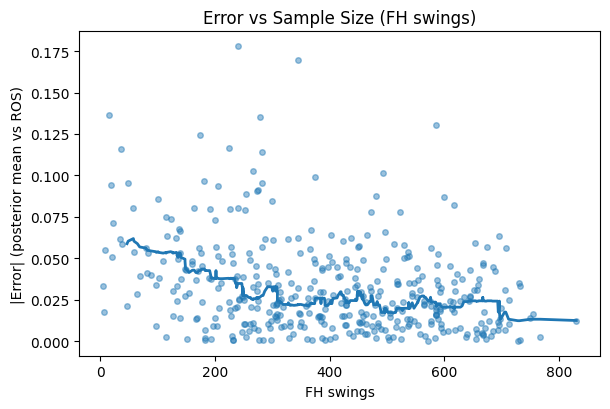

In [81]:
import os, numpy as np, pandas as pd
import matplotlib.pyplot as plt

os.makedirs("reports/figs", exist_ok=True)

# E must contain: batter_id, proj_p, contact_rate_ROS, swings_FH
E["abs_err"] = (E["proj_p"] - E["contact_rate_ROS"]).abs()

plt.figure(figsize=(6.2,4.2))
plt.scatter(E["swings_FH"], E["abs_err"], s=16, alpha=0.45)
plt.xlabel("FH swings")
plt.ylabel("|Error| (posterior mean vs ROS)")
plt.title("Error vs Sample Size (FH swings)")

# rolling median to show trend
e_sorted = E.sort_values("swings_FH")
k = 35
med = e_sorted["abs_err"].rolling(k, min_periods=max(5, k//3)).median()
plt.plot(e_sorted["swings_FH"], med, lw=2)

plt.tight_layout()
plt.savefig("reports/figs/error_vs_swings.png", dpi=180)
plt.show()


In [ ]:
'''
These two bar charts summarize how prediction interval quality changes with hitter sample size (first-half swings).

Left chart: The 80% coverage rate shows how often true contact rates fall inside the model’s predicted interval.

Coverage stabilizes around 0.5–0.65, improving slightly with more swings — small-sample hitters (≤100 swings) are less 
reliable but reasonably captured.

Right chart: The average interval width (uncertainty) narrows as sample size increases — hitters with more swings have tighter,
more confident intervals.
'''

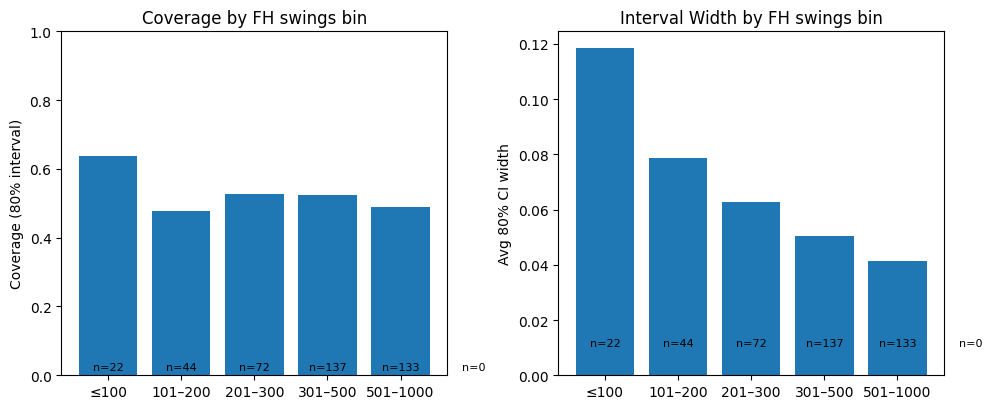

In [84]:
import numpy as np
import matplotlib.pyplot as plt

# make bins & compute coverage, avg width
E["hit80"] = ((E["contact_rate_ROS"] >= E["lo80"]) & (E["contact_rate_ROS"] <= E["hi80"])).astype(int)
E["ci80_width"] = (E["hi80"] - E["lo80"])

E["sw_bin"] = pd.cut(
    E["swings_FH"],
    bins=[0,100,200,300,500,1000,10_000],
    labels=["≤100","101–200","201–300","301–500","501–1000",">1000"],
    include_lowest=True, right=True
)

g = (E.groupby("sw_bin", observed=False)
       .agg(Coverage_80=("hit80","mean"),
            Avg_CI80_Width=("ci80_width","mean"),
            n=("batter_id","size"))
       .reset_index())

fig, ax = plt.subplots(1,2, figsize=(10,4.2), sharex=True)
ax[0].bar(g["sw_bin"].astype(str), g["Coverage_80"])
ax[0].set_ylim(0,1)
ax[0].set_ylabel("Coverage (80% interval)")
ax[0].set_title("Coverage by FH swings bin")

ax[1].bar(g["sw_bin"].astype(str), g["Avg_CI80_Width"])
ax[1].set_ylabel("Avg 80% CI width")
ax[1].set_title("Interval Width by FH swings bin")

for a in ax:
    for xt, nn in zip(a.get_xticks(), g["n"]):
        a.text(xt, a.get_ylim()[0]+0.01, f"n={nn}", ha="center", va="bottom", fontsize=8)

plt.tight_layout()
plt.savefig("reports/figs/coverage_by_bin.png", dpi=180)
plt.show()


In [ ]:
'''
These side-by-side bar charts identify hitters whose first-half contact rate (FH) meaningfully diverged from their projected 
true skill (Empirical Bayes estimate).

Left chart (Underperformers): Hitters whose projected contact ability (Proj) is higher than what they showed in the first half,
they likely underperformed and may improve going forward.

Right chart (Overperformers): Hitters whose first-half results exceeded their projected skill, they likely overperformed and 
could regress toward their true level.
'''

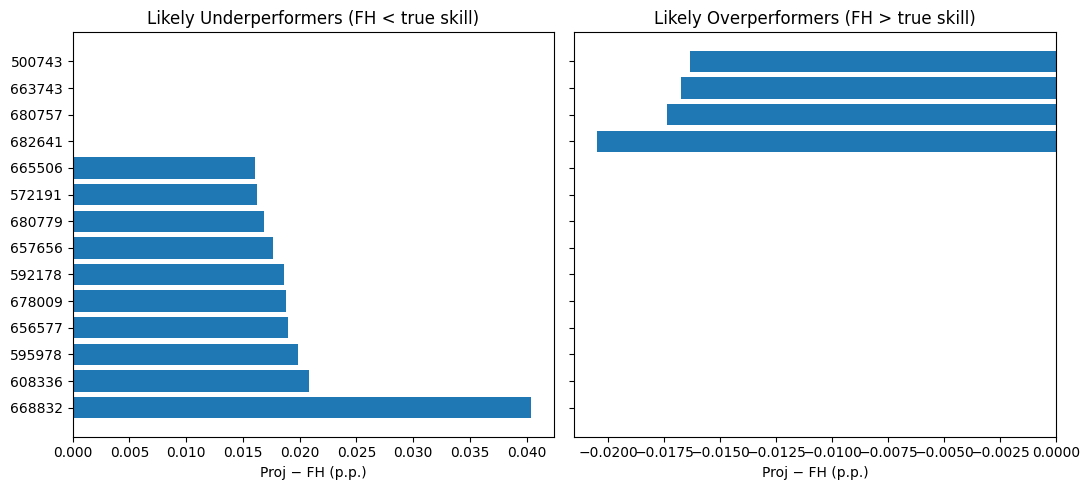

In [85]:
import matplotlib.pyplot as plt

# Recreate Tier-3 screens (adjust thresholds if you like)
underperf = (eb_out.query("delta_vs_FH >= 0.015 and swings_FH >= 150")
                   .sort_values("delta_vs_FH", ascending=False)
                   .head(10))
overperf  = (eb_out.query("delta_vs_FH <= -0.015 and swings_FH >= 150")
                   .sort_values("delta_vs_FH", ascending=True)
                   .head(10))

fig, ax = plt.subplots(1,2, figsize=(11,5), sharey=True)

ax[0].barh(underperf["batter_id"].astype(str), underperf["delta_vs_FH"])
ax[0].invert_yaxis()
ax[0].set_title("Likely Underperformers (FH < true skill)")
ax[0].set_xlabel("Proj − FH (p.p.)")

ax[1].barh(overperf["batter_id"].astype(str), overperf["delta_vs_FH"])
ax[1].invert_yaxis()
ax[1].set_title("Likely Overperformers (FH > true skill)")
ax[1].set_xlabel("Proj − FH (p.p.)")

plt.tight_layout()
plt.savefig("reports/figs/watchlist_bars.png", dpi=180)
plt.show()


In [ ]:
#Generating Report

In [103]:

os.system(
    "jupyter nbconvert contact_projection.ipynb --to html "
    "--output ../reports/report.html --no-input"
)
print("✅ Exported to ../reports/report.html")


[NbConvertApp] Converting notebook contact_projection.ipynb to html


✅ Exported to ../reports/report.html


[NbConvertApp] WARNING | Alternative text is missing on 3 image(s).
[NbConvertApp] Writing 484984 bytes to ../reports/report.html
